In [1]:
import keras
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Using TensorFlow backend.


In [2]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [3]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [4]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [5]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
import numpy as np
step = 0.01  
num_octave = 3  
octave_scale = 1.4
iterations = 20  
max_loss = 10.
base_image_path = '/Users/r/Documents/python3_y2q2/rabbit.jpg'
img = preprocess_image(base_image_path)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    #save_img(img, fname='Dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_pic.png')

Processing image shape (188, 239)
...Loss value at 0 : 1.5683775
...Loss value at 1 : 2.1173375
...Loss value at 2 : 2.8313494
...Loss value at 3 : 3.5143726
...Loss value at 4 : 4.0147524
...Loss value at 5 : 4.7251816
...Loss value at 6 : 5.183625
...Loss value at 7 : 5.705802
...Loss value at 8 : 6.168896
...Loss value at 9 : 6.704525
...Loss value at 10 : 7.194256
...Loss value at 11 : 7.6367393
...Loss value at 12 : 7.9955497
...Loss value at 13 : 8.403795
...Loss value at 14 : 8.886509
...Loss value at 15 : 9.246337
...Loss value at 16 : 9.6836195
...Loss value at 17 : 9.99138
Processing image shape (264, 335)
...Loss value at 0 : 2.8926833
...Loss value at 1 : 4.2815824
...Loss value at 2 : 5.404204
...Loss value at 3 : 6.2808313
...Loss value at 4 : 7.117509
...Loss value at 5 : 7.880212
...Loss value at 6 : 8.565778
...Loss value at 7 : 9.247558
...Loss value at 8 : 9.813672
Processing image shape (370, 470)
...Loss value at 0 : 3.0298166
...Loss value at 1 : 4.338856
...Loss 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


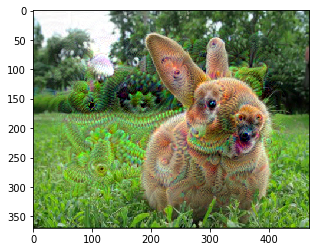

In [7]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()